# Clustering Orange survey data with k-Means, DBSCAN and Hierarchical clustering
  

In [1]:
import pandas as pd
from sklearn.manifold import TSNE,MDS
import umap
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN,KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score,davies_bouldin_score, adjusted_rand_score, mutual_info_score,cohen_kappa_score, homogeneity_score
import community
import networkx as nx
from sklearn import metrics
import sklearn.neighbors as sk
import numpy as np
from collections import Counter


First we read the data and preprocess it for later use. We can remove few unrelavent atributes like: "Start Date (UTC)", "Submit Date (UTC)", "Network ID", "#", "Other", "Other.1", "Other.2", "Other.3". All atributes in data are categorical. If we can look at columns "Excel", "IBM SPSS Statistics", "KNIME", "MATLAB", "Python", "Python Pandas", "R", "Rapid Miner","SQL", "Weka","None", we can see that this columns structure can be changed to binary form. 

In [2]:
data = pd.read_csv("../data/Orange questionnaire.csv")
print("Data dimensionality: "+ str(data.shape[0])+" instances x "+str(data.shape[1])+" features")

data = data.drop("#", axis=1)
data = data.drop("Other", axis=1)
data = data.drop("Other.1", axis=1)
data = data.drop("Other.2", axis=1)
data = data.drop("Other.3", axis=1)
data = data.drop("Start Date (UTC)", axis=1)
data = data.drop("Submit Date (UTC)", axis=1)
data = data.drop("Network ID", axis=1)

org = data.copy(deep=False)
original = data.copy(deep=False)
for n in range(3, 15):
    data.iloc[:, n] = (~data.iloc[:, n].isnull()).astype(int)
    
original["Where do you work?"] = original["Where do you work?"].fillna("Other")
for n in range(3, 15):
    tmp = (data.iloc[:, n].value_counts()/len(data)).to_dict()
    data.iloc[:, n] = data.iloc[:, n].replace(tmp)


print("Features after manual feature selection: "+ str(data.shape[1]))




Data dimensionality: 19681 instances x 23 features
Features after manual feature selection: 15


#### Data analysis and visualization

Here we present each attribute with graph, so we can look how attributes are structured.

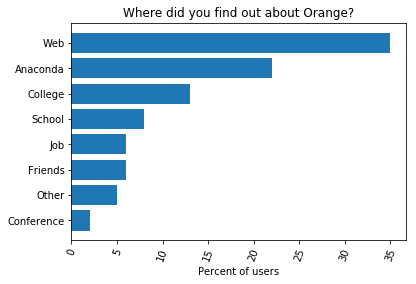

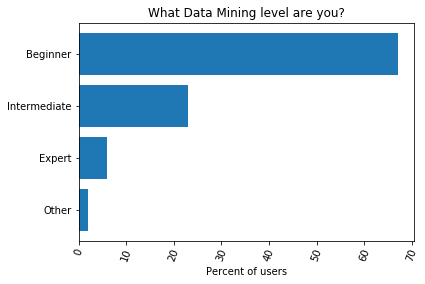

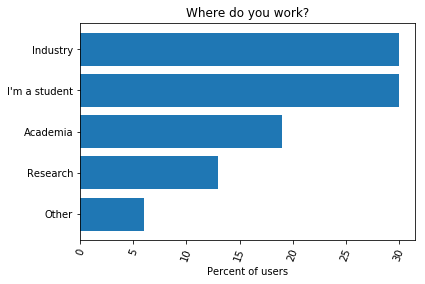

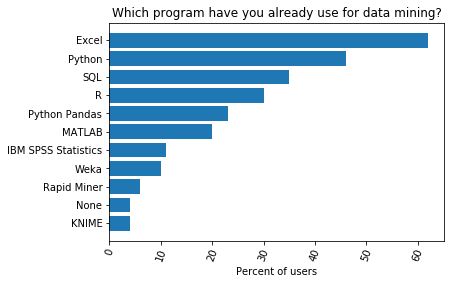

Monthly tips?: Yes(26.8%), No(73.2%)


In [3]:
for n in range(0, 3):
    org.iloc[:, n] = org.iloc[:, n].fillna("Other")
    tmp = (org.iloc[:, n].value_counts()/len(org))
    val = tmp.values
    vals = []
    for v in val:
        vals.append(int(v*100))
    join = sorted(list(zip(vals,tmp.index.values)))
    plt.barh( [val[1] for val in join],[val[0] for val in join], align='center')
    plt.xlabel("Percent of users")
    plt.title(tmp.name)
    plt.xticks(rotation=70)
    plt.show()

key = ['Excel','IBM SPSS Statistics','KNIME','MATLAB','Python','Python Pandas','R','Rapid Miner','SQL','Weka', 'None']
val = []
for col in key:
    tmp = org[col].value_counts()/len(org)
    val.append(int(tmp.get(col)*100))
    
join = sorted(list(zip(val,key)))

plt.barh([val[1] for val in join],[(val[0]) for val in join], align='center')
plt.xlabel("Percent of users")
plt.title("Which program have you already use for data mining?")
plt.xticks(rotation=70)
plt.show()

monthlyTips = (~original["Monthly tips"].isnull()).astype(int).value_counts(normalize=True).values

print("Monthly tips?: Yes("+str(round(monthlyTips[1]*100,1))+"%), No("+str(round(monthlyTips[0]*100,1))+"%)")




We change cetegorical string data to numeric values, so we can caluclate the euclidean distance between elements. We change all empty values with number 0.

In [4]:
level = {"Expert": 3, "Beginner": 1, "Intermediate": 2, 0: 0, "NaN": 0}

job = {"Academia": 3, "Research": 1, "I'm a student": 2, "Other": 0, "Industry": 4, 0:0}

find_out = {"College": 1, "Conference": 2, "Web": 3, "Friends": 4, "School": 5, "Job": 6, "Anaconda": 7, 0: 0}


data["Where do you work?"] = data["Where do you work?"].fillna(0)
data["Where do you work?"] = data["Where do you work?"].replace(job)


data["What Data Mining level are you?"] = data["What Data Mining level are you?"].fillna(0)
data["What Data Mining level are you?"] = data["What Data Mining level are you?"].replace(level)

data["Where did you find out about Orange?"] = data["Where did you find out about Orange?"].fillna(0)
data["Where did you find out about Orange?"] = data["Where did you find out about Orange?"].replace(find_out)




Then we use t-SNE method for dimension reduction, so we can visualize multidimensional data in 2D space. We use t-SNE with different parameters, so we can se the difference how structure changes.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


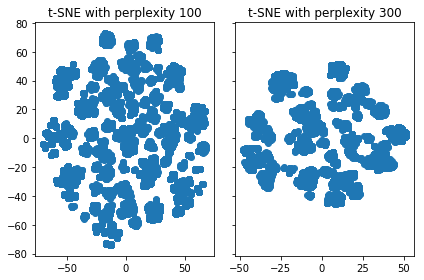

In [5]:
data_2D_100 = TSNE(n_components=2, perplexity=100).fit_transform(data)
data_2D_300 = TSNE(n_components=2, perplexity=300).fit_transform(data)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.scatter(data_2D_100[:, 0], data_2D_100[:, 1])
ax1.set_title('t-SNE with perplexity 100')
ax2.scatter(data_2D_300[:, 0], data_2D_300[:, 1])
ax2.set_title('t-SNE with perplexity 300')
f.tight_layout()
f.show()


We use another dimension reduction method called UMAP, so we can compare it to t-SNE.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 194 separate connected components using meta-embedding (experimental)
  n_components
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/sparse/csgraph/_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/spectral.py:182: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/Library/Frameworks/Python.framework/Version

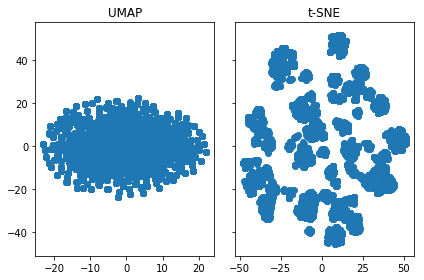

In [6]:
UMAP_2D = umap.UMAP().fit_transform(data)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.scatter(UMAP_2D[:, 0], UMAP_2D[:, 1])
ax1.set_title('UMAP')
ax2.scatter(data_2D_300[:, 0], data_2D_300[:, 1])
ax2.set_title('t-SNE')
f.tight_layout()
f.show()

## Clustering with k-MEANS method

With elbow method [Robert L. Thorndike,1953], we try to figure out the optimal number of clusters. From our graph we can notice that elbow appears near two clusters, so our $k$-parameter will be 2. Later we test this pick with silhouette score, so we can verified that 2 clusters are really the optimal number of clusters.

Text(0,0.5,'WCSS')

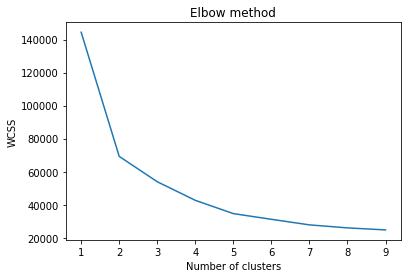

In [7]:
k_means_results = []
for n_clusters in range(1,10):
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    cluster_labels = clusterer.fit_predict(data)
    k_means_results.append(clusterer.inertia_)
plt.plot(range(1,10),k_means_results)
plt.title("Elbow method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")

We calculate the silhouette score for $k$-MEANS with a value $k$ between 2 and 6 and as we can se, the best score is when we partition the data on two cluster, so we can verified that the optimal number of clusters is 2.

In [8]:
bestScore = -1
kmeans_labels = []
print("Silhouette scores: ")
for n_clusters in range(2,7):
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(data)
    silhouette_avg = silhouette_score(data, cluster_labels)
    if silhouette_avg > bestScore:
        bestScore = silhouette_avg
        kmeans_labels = cluster_labels
    print(str(n_clusters)+" clusters: "+str(round(silhouette_avg,3)))

Silhouette scores: 
2 clusters: 0.448
3 clusters: 0.353
4 clusters: 0.361
5 clusters: 0.346
6 clusters: 0.346


This function is used for preprocesing clusters for visualisation. Order both list the same.

In [9]:
def set_list(pos,l1,v1,l2,v2):
    list1 = []
    list2 = []
    for el in pos:
        if el in l1:
            ind = l1.index(el)
            list1.append(v1[ind])
        else:
            list1.append(0)
        if el in l2:
            ind1 = l2.index(el)
            list2.append(v2[ind1])
        else:
            list2.append(0)
    return list1,list2
        
    

This funciton is used for cluster representation and comparison. For each atribute we make a graph, so we can compare clusters to each other.

In [10]:
def get_cluster_statistic(labels):
    original['clusters'] = pd.Series(labels, index=original.index)
    test2 = original.groupby(['clusters'])
    cluster_1 = test2.get_group(0)
    cluster_2 = test2.get_group(1)
    for n in range(0,3):
        clus1 = (cluster_1.iloc[:, n].value_counts(normalize=True))
        clus1_val = []
        for v in clus1.values:
            clus1_val.append(int(v*100))
        clus2 = (cluster_2.iloc[:, n].value_counts(normalize=True))
        clus2_val = []
        for v in clus2.values:
            clus2_val.append(int(v*100))
        
        xlabel = list(set(list(clus1.index.values) + list(clus2.index.values)))
        val1,val2 = set_list(xlabel,list(clus1.index.values),clus1_val, list(clus2.index.values),clus2_val)
        x = np.arange(len(xlabel))
        
        plt.figure(figsize=(10,7))
        p1 = plt.bar(x, val1, width=0.25,color='b',align='center')
        p2 = plt.bar(x+0.25, val2, width=0.25,color='g',align='center')

        plt.ylabel('Precent of users')
        plt.title('Comparing Cluster 1 and Cluster 2')
        plt.xticks(x,xlabel)
        plt.yticks([0,25,50,75,100])
        plt.legend(["Cluster 1", "Cluster 2"])

        plt.show()

    key = ['Excel','IBM SPSS Statistics','KNIME','MATLAB','Python','Python Pandas','R','Rapid Miner','SQL','Weka', 'None']
    clus1_val = []
    clus2_val = []
    for col in key:
        clus1 = cluster_1[col].fillna(0).value_counts(normalize=True)
        clus2 = cluster_2[col].fillna(0).value_counts(normalize=True)
        clus1_val.append(int(clus1.get(col)*100))
        clus2_val.append(int(clus2.get(col)*100))
    
    x = np.arange(len(key))
    plt.figure(figsize=(12,7))
    p1 = plt.bar(x, clus1_val, width=0.25,color='b',align='center')
    p2 = plt.bar(x+0.25, clus2_val, width=0.25,color='g',align='center')
    
    plt.ylabel('Precent of users')
    plt.title('Comparing Cluster 1 and Cluster 2')
    plt.xticks(x,key, fontsize=8)
    plt.yticks([0,25,50,75,100])
    plt.legend(["Cluster 1", "Cluster 2"])

    plt.show()
    
            


Here we visualize results of K-means clustering. We compare clusters to each other. so we can see what is the difference between clusters. The biggest difference appears in the first graph which represents the attribute "Where did you find out about Orange?".  The first cluster contains only three attributes out of eight and those are: "Anaconda", "School" and "Job". The second cluster contains the remaining four attributes: "College", "Web", "Other", "Friends" and "Conference". All the other graphs are nearly the same.

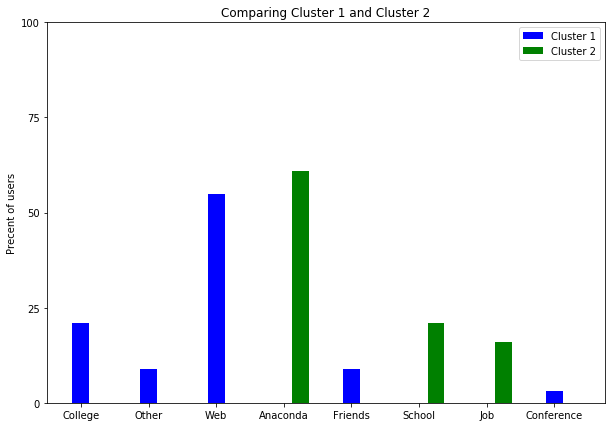

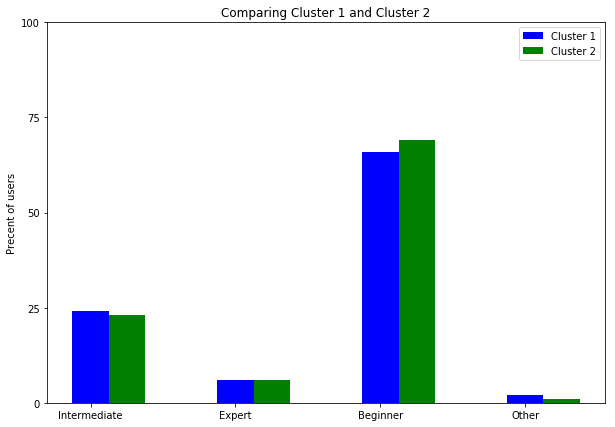

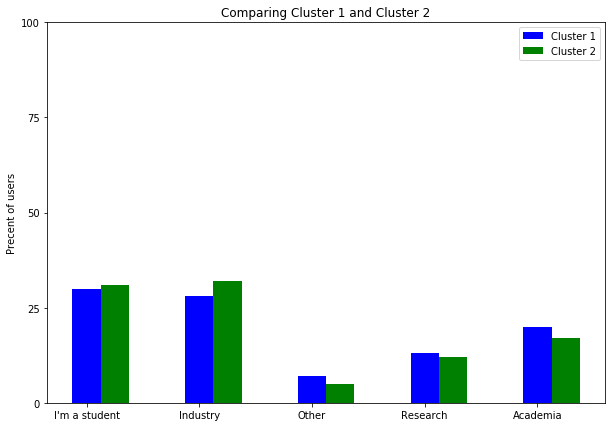

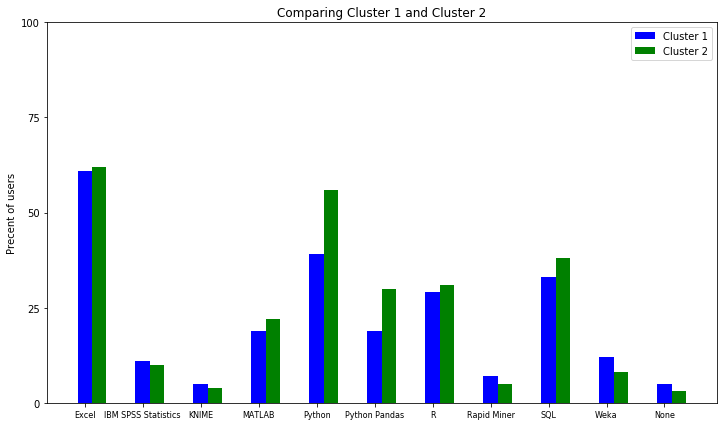

In [11]:
get_cluster_statistic(kmeans_labels)

### Clustering with DBSCAN method

Here we preform clustering on data with DBSCAN method. With elbow method, we try to figure out the optimal parameter eps. The results of clustering are rated with the silhouette score.

This function returns the distances to k-neighbour. We use it for elbow method mentioned lower.

In [12]:
def k_dist(X, metric, k=3):
        data = []
        tree = sk.KDTree(X, leaf_size=30)
        for n,point in enumerate(X):
            dist, ind = tree.query([point], k=k)
            data.append(dist[0].tolist()[k-1])
        return data

To estimate the parameter $eps$, we resort to the elbow method [Robert L. Thorndike,1953] and use distance to the k-neighbour <cite>[Martin Ester & Hans-Peter Kriegel, 1996]</cite>.

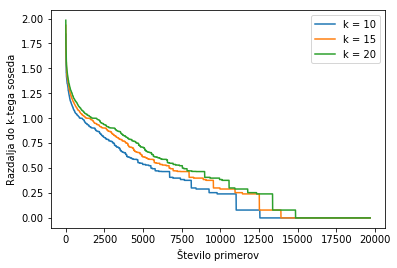

In [13]:
plt.plot(sorted(k_dist(data.values, '', 10), reverse=True))
plt.plot(sorted(k_dist(data.values, '', 15), reverse=True))
plt.plot(sorted(k_dist(data.values, '', 20), reverse=True))

plt.legend(["k = 10", "k = 15", "k = 20"])
plt.xlabel('Število primerov')
plt.ylabel('Razdalja do k-tega soseda')
plt.show()

Here we performe DBSCAN clustering. We try to figure the $elbow$ out from the graph above for the $eps$ parameter, but when we run the DBSCAN with that parameter, we get only one clusters with some noise points. What should i do here? 

In [14]:
db = DBSCAN(eps=1.05, min_samples=10).fit(data)
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(data, labels))
dbscan_labels = labels

Estimated number of clusters: 1
Estimated number of noise points: 200
Silhouette Coefficient: 0.179


## Hierarchical clustering

The last clustering method that we are going to use is hierarchical clustering. We test hierarchical clustering with 2,3,4,5 and 6 clusters and for each we caluculate the silhouette score. As we can see, we get the best score with 2 clusters, the same as k-MEANS method.

In [15]:
print("Silhouette scores: ")
for n in range(2,7):
    clustering = AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                connectivity=None, linkage='ward', n_clusters=n).fit(data)
    hierarc = clustering.labels_
    print(str(n)+" clusters: "+str(round(silhouette_score(data, hierarc),3)))

Silhouette scores: 
2 clusters: 0.43
3 clusters: 0.34
4 clusters: 0.322
5 clusters: 0.287
6 clusters: 0.284


Here we performe the hierarchical clustering so we get two clusters. We visualize those two clusters in 2D space, so we can see how the data is split. 

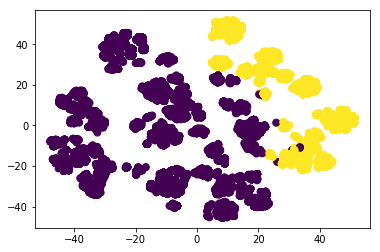

In [16]:
clustering = AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                connectivity=None, linkage='ward', n_clusters=2).fit(data)
hierarc = clustering.labels_
plt.scatter(data_2D_300[:, 0], data_2D_300[:, 1], c=hierarc, s=50, cmap='viridis')

Here we visualize results of hierarchical clustering. We compare clusters to each other. so we can see what is the difference between clusters. As we can se, results are very similar to the results of K-means clustering. The biggest difference appears in the first graph which represents the attribute "Where did you find out about Orange?".  The first cluster contains only three attributes out of eight and those are: "Anaconda", "School" and "Job". The second cluster contains five attributes: "College", "School" "Web", "Other", "Friends" and "Conference". All the other graphs are nearly the same.

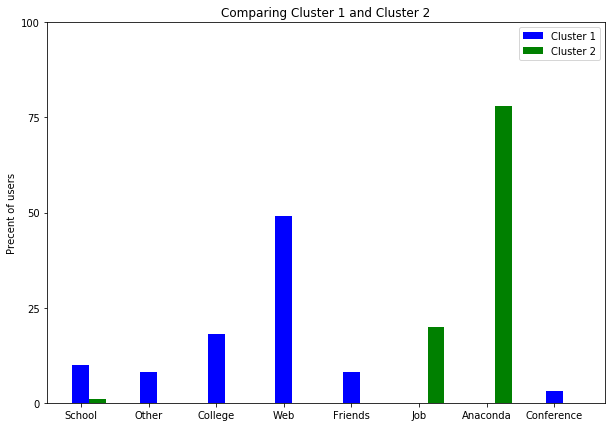

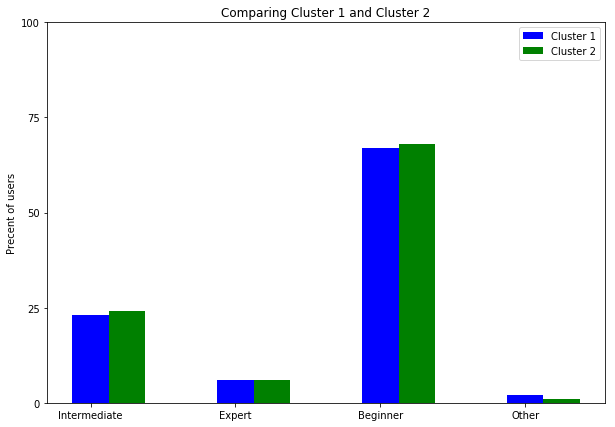

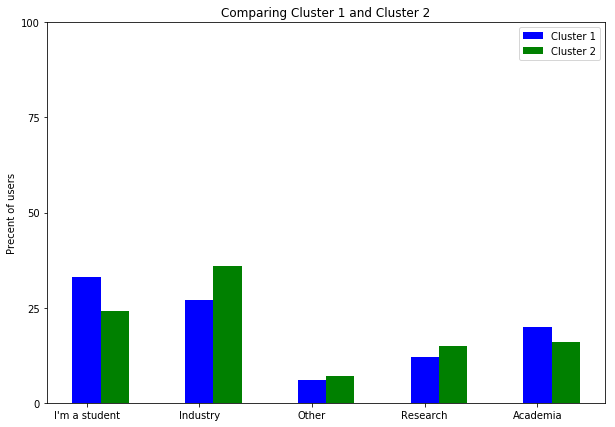

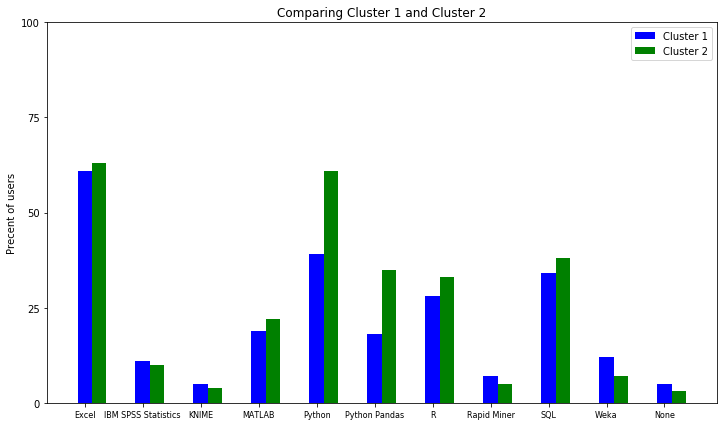

In [17]:
get_cluster_statistic(hierarc)

### Comparing results

Comparing results from DBSCAN, K-means and hierarchical clustering. We use adjusted rand index to compute similarity between results and then present similarities in corelation matrix. From the matrix we can see, that results from K-means and hierarchical clustering are similar. The results of DBSCAN is terrible if we compare it to other two methods. DBSCAN probably fails because of the large similarity between points.

In [20]:
hierarchical_=[adjusted_rand_score(hierarc, hierarc),adjusted_rand_score(hierarc, dbscan_labels), adjusted_rand_score(hierarc, kmeans_labels)]

dbscan_ = [adjusted_rand_score(dbscan_labels, hierarc), adjusted_rand_score(dbscan_labels, dbscan_labels),adjusted_rand_score(dbscan_labels, kmeans_labels)]

k_means_ = [adjusted_rand_score(kmeans_labels, hierarc),adjusted_rand_score(kmeans_labels, dbscan_labels),adjusted_rand_score(kmeans_labels, kmeans_labels)]

results_clustering = pd.DataFrame(
    {'Hiearchical': hierarchical_,
     'DBSCAN': dbscan_,
     'k-MEANS': k_means_
    })

print(results_clustering.corr())

             Hiearchical    DBSCAN   k-MEANS
Hiearchical     1.000000 -0.959831  0.841977
DBSCAN         -0.959831  1.000000 -0.959532
k-MEANS         0.841977 -0.959532  1.000000


[1]:https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf